In [1]:
import nibabel as nib
import torch
import os
from tqdm.notebook import trange,tqdm
import torch.nn.functional as F
import torch.nn as nn
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(torch.cuda.get_device_name())

torch.cuda.set_per_process_memory_fraction(0.25, 0)


NVIDIA A100 80GB PCIe


In [2]:
train_source_data = torch.load('HackathonDA_CHAOS_T1_source.pth')['train_source_data']
pseudo_source_data = torch.load('HackathonDA_CHAOS_T1_source.pth')['pseudo_source_data']
for pseudo in pseudo_source_data: 
    train_source_data.append(pseudo)
len(train_source_data)

40

/shared/team2/segmentation_models.pytorch/.venv/lib/python3.9/site-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/shared/team2/segmentation_models.pytorch/.venv/lib/python3.9/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


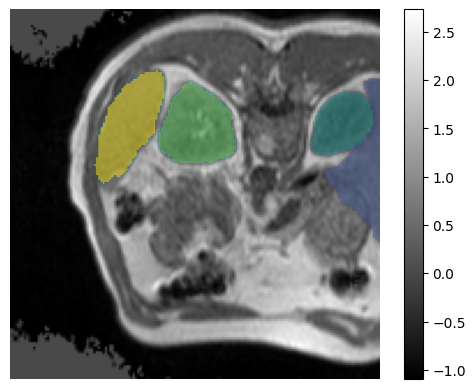

In [3]:
def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice

def load_batch_train(train_data,batch_idx,affine_rand=0.05):
    num_batch = len(batch_idx)
    train_img = torch.zeros(num_batch,2,160,160).cuda()
    train_label = torch.zeros(num_batch,160,160).cuda().long()
    for b in range(num_batch):
        with torch.no_grad():
            data = train_data[batch_idx[b]]
            rand_slice = torch.randint(data.shape[1],(1,))
            rand_patch1 = torch.randint(max(data.shape[2]-160,1),(1,))
            rand_patch2 = torch.randint(max(data.shape[3]-160,1),(1,))
            grid = F.affine_grid(torch.eye(2,3).unsqueeze(0).cuda()+affine_rand*torch.randn(1,2,3).cuda(),(1,1,max(data.shape[2],160),max(data.shape[3],160)))
            patch_grid = grid[:,rand_patch1:rand_patch1+160,rand_patch2:rand_patch2+160,:]
            train_img[b,:2] = F.grid_sample(data[0:2,rand_slice].transpose(1,0).cuda(),patch_grid).squeeze()
            train_label[b] = F.grid_sample(data[-1:,rand_slice].cuda(),patch_grid,mode='nearest').squeeze().long()
    return train_img,train_label.clamp_min_(0)

train_img,train_label = load_batch_train(train_source_data,torch.arange(10,26))
N = torch.argmax((train_label==3).sum([1,2]),0)
plt.imshow(train_img[N,0].cpu(),'gray')
plt.colorbar()
plt.imshow(train_label[N].cpu(),alpha=.5*(train_label[N].cpu()>0).float())
plt.axis('off')
plt.show()

In [4]:
model = []
dim = 64
model.append(nn.Conv2d(2,dim,2,stride=2,bias=False))
model.append(nn.GroupNorm(4,dim))
model.append(nn.ReLU())
model.append(nn.Conv2d(dim,dim,3,padding=1,bias=False))
model.append(nn.GroupNorm(4,dim))
model.append(nn.ReLU())
model.append(nn.Conv2d(dim,dim*2,3,padding=1,stride=2,bias=False))
model.append(nn.GroupNorm(4,dim*2))
model.append(nn.ReLU())
model.append(nn.Conv2d(dim*2,dim*2,3,padding=1,bias=False))
model.append(nn.GroupNorm(4,dim*2))
model.append(nn.ReLU())
model.append(nn.UpsamplingBilinear2d(scale_factor=4))
model.append(nn.Conv2d(dim*2,dim//2,3,padding=1,bias=False))
model.append(nn.GroupNorm(4,dim//2))
model.append(nn.ReLU())
model.append(nn.Conv2d(dim//2,5,3,padding=1,bias=False))

model = nn.Sequential(*model).cuda()



In [5]:

num_iterations = 3000
        
optimizer = torch.optim.Adam(model.parameters(),lr=0.002)
run_loss = torch.zeros(num_iterations,3)
t0 = time.time()
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,num_iterations//3,2)


with tqdm(total=num_iterations, file=sys.stdout) as pbar:


    for i in range(num_iterations):
        optimizer.zero_grad()

        batch_idx = torch.randperm(30)[:16]+10
        train_img,train_label = load_batch_train(train_source_data,batch_idx)

        output = model(train_img)

        loss = nn.CrossEntropyLoss()(output,train_label.long())
        loss.backward()
        optimizer.step()
        scheduler.step()
        run_loss[i,0] = loss.item()
        
        if(i%4==3):
            with torch.no_grad():
                
                val_source_img,val_source_label = load_batch_train(train_source_data,torch.arange(10),affine_rand=0)
                output_val = model(val_source_img)

                d_val = dice_coeff(output_val.argmax(1),val_source_label.long(),5)
                run_loss[i-3:i+1,1] = (d_val.mean())
                
        str1 = f"iter: {i}, CE: {'%0.3f'%(run_loss[i-28:i-1,0].mean())}, src-Dice: {'%0.3f'%(run_loss[i-28:i-1,1].mean())}, runtime: {'%0.3f'%(time.time()-t0)} sec, GPU max/memory: {'%0.2f'%(torch.cuda.max_memory_allocated()*1e-9)} GByte"
        pbar.set_description(str1)
        pbar.update(1)


  0%|          | 0/3000 [00:00<?, ?it/s]

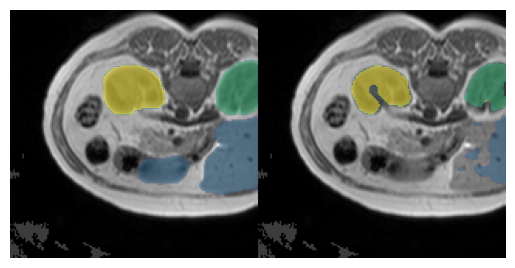

In [6]:
N = torch.argmax((val_source_label==3).sum([1,2]),0)
val_and_pred = torch.cat((val_source_label[N],output_val.argmax(1)[N]),1).data.cpu()
plt.imshow(val_source_img[N,0].cpu().repeat(1,2),'gray')
plt.imshow(val_and_pred,alpha=.5*(val_and_pred>0).float())
plt.axis('off')
plt.show()

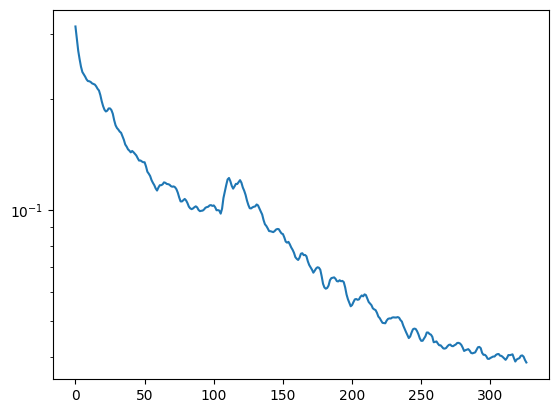

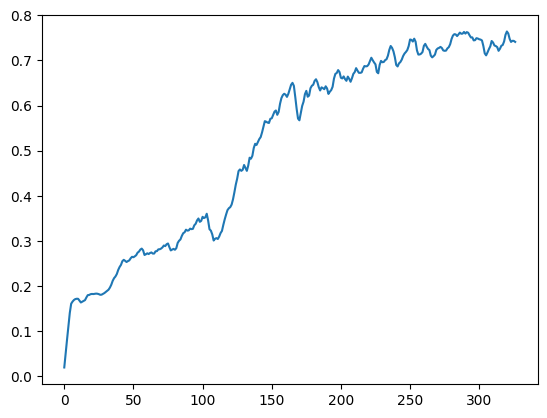

In [7]:
plt.semilogy(F.avg_pool1d(F.avg_pool1d(run_loss[:i,0].view(1,1,-1),15,stride=3),15,stride=3).squeeze())
plt.show()
plt.plot(F.avg_pool1d(F.avg_pool1d(run_loss[:i,1].view(1,1,-1),15,stride=3),15,stride=3).squeeze())
plt.show()